In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, calinski_harabasz_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
# bayestian hyperparameter tunning
import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# models to try
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from myvars import input_features
from myfuncs import num_describe, generate_features
from myclasses import Windsorizer


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Simulate future data

In [2]:
def separate_data():
    data = pd.read_csv('../data/processed/data.csv')
    data = data.dropna(subset=input_features)
    data = generate_features(data)
    data.query("calendarYear > 2018").to_csv('../data/processed/future.csv', index=False)
    data.query("calendarYear <= 2018").to_csv('../data/processed/present.csv', index=False)
    return None

In [3]:
separate_data()

# Train on different models

In [4]:
data = pd.read_csv('../data/processed/present.csv')
features = data.drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate'])
target = data.target

#### Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    np.log(target), 
    test_size=0.25, 
    random_state = 46)
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(5925, 64), (1975, 64), (5925,), (1975,)]

In [6]:
pd.concat([X_train,y_train], axis=1).to_csv('../data/processed/train.csv', index=False)
pd.concat([X_test,y_test], axis=1).to_csv('../data/processed/test.csv', index=False)

#### No model

In [7]:
n = len(y_test)
mean = y_train.mean()
worst_preds = np.tile(mean, n)
mean_squared_error(y_true=np.exp(y_test), y_pred = np.exp(worst_preds))

4624.240947756172

#### Linear Regression

In [8]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [10]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 739.9144617191712
mse test:  552.3804513056559
rmse test:  23.50277539580498


#### Polynomial Regression

In [11]:
def do_poly_regression(pipe, X_train, X_test, y_train, y_test=None, degree = 2):
    pipe.steps.append(('poly_transform', PolynomialFeatures(degree=degree)))
    pipe.steps.append(('regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_poly_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 290.9250096950543
mse test:  3.965944527788969e+120
rmse test:  1.991467932905014e+60


- **Insane Overfit**. 1e113 order of magnitude

#### Linear SVR

In [12]:
def do_linear_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_svm', LinearSVR(C=0.02, max_iter=1000)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 692.0856264052034
mse test:  566.0197971690108
rmse test:  23.791170571642976


- Check ill-conditioning. For C's larger than 0.02 it stops converging despite max_iter being 1000

#### SVM with radial basis functions

In [13]:
def do_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rbf_svm', SVR(kernel = 'rbf', C=1.5, epsilon=0.1)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 406.4348664425852
mse test:  525.2940160311748
rmse test:  22.919293532549705


Pipeline(steps=[('scaler', PowerTransformer()), ('rbf_svm', SVR(C=1.5))])

- Nice

#### KNN

In [20]:
def do_neighbors(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rfe', RFE(estimator = LinearRegression(), n_features_to_select = 5)))
    pipe.steps.append(('knn', KNeighborsRegressor(n_neighbors=5)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_neighbors(mypipe, X_train, X_test, y_train, y_test)

mse train: 602.5579938237018
mse test:  636.0603936293599
rmse test:  25.22023777900121


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=5)),
                ('knn', KNeighborsRegressor())])

- ok

#### Random Forest
- Including some basic hyperparameter tunning trying skopt interface for BayesSearch

In [14]:
def search_forest(pipe, X_train, X_test, y_train, y_test=None):
    model = RandomForestRegressor()
    param_grid={
        'max_depth':(3,10),
        'min_samples_leaf':(1e-3, 0.1, 'log-uniform'),
        'min_samples_split':(1e-3, 0.1, 'log-uniform'),
    }
    pipe.steps.append(('forest_optimizer', BayesSearchCV(model, search_spaces=param_grid, n_iter = 5, n_jobs=5,n_points = 5, verbose = 10, )))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
mypipe = search_forest(mypipe, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
mse train: 292.47084581120157
mse test:  428.3632211142772
rmse test:  20.696937481527968


In [15]:
a = mypipe['forest_optimizer']
a.best_params_, a.best_score_

(OrderedDict([('max_depth', 9),
              ('min_samples_leaf', 0.0010256600861588028),
              ('min_samples_split', 0.0023241843515524204)]),
 0.912892830173391)

- High overfitting because RF has no regularization process

#### Gradient Boosting
- Change scorer to a better suited one. Abandoned, takes ages, skopt wasn't working out, back to optuna

In [16]:
def custom_score(y, y_pred, **kwargs):
    return mean_squared_error(y_true=np.exp(y), y_pred=np.exp(y_pred))

In [29]:
def search_boosting(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "verbosity": 0,
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 50, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 3, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mse

    minutes = 20
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

results, study = search_boosting(mypipe, X_train, X_test, y_train, y_test)

[I 2022-04-18 21:00:07,007] A new study created in memory with name: no-name-de9fc285-29a4-401d-8f8f-2efa2b0114dd
[I 2022-04-18 21:00:09,403] Trial 0 finished with value: 1233.912998370788 and parameters: {'min_child_weight': 280, 'alpha': 7.544210358282202e-06, 'max_depth': 3, 'colsample_bytree': 0.9812658835139896, 'subsample': 0.7016763104835662, 'eta': 0.03553521394113833}. Best is trial 0 with value: 1233.912998370788.
[I 2022-04-18 21:00:12,382] Trial 1 finished with value: 3249.5011786155214 and parameters: {'min_child_weight': 196, 'alpha': 0.014417590669328092, 'max_depth': 10, 'colsample_bytree': 0.9076817037094591, 'subsample': 0.8604259756615673, 'eta': 0.014044059968842188}. Best is trial 0 with value: 1233.912998370788.
[I 2022-04-18 21:00:14,780] Trial 2 finished with value: 2100.8175466587295 and parameters: {'min_child_weight': 55, 'alpha': 0.03871534247357528, 'max_depth': 4, 'colsample_bytree': 0.6917176393036867, 'subsample': 0.7491232252943925, 'eta': 0.02003148095

In [32]:
study.best_trial.value, study.best_trial.params

(286.40738209295756,
 {'min_child_weight': 58,
  'alpha': 0.027230585245890622,
  'max_depth': 10,
  'colsample_bytree': 0.505661088108428,
  'subsample': 0.6226860565996696,
  'eta': 0.1485581680577813})

Assess results

In [21]:
params =  {
    'min_child_weight': 58,
    'alpha': 0.027230585245890622,
    'max_depth': 10,
    'colsample_bytree': 0.505661088108428,
    'subsample': 0.6226860565996696,
    'eta': 0.1485581680577813
  }
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(X_train,y_train)
preds_test = pipe.predict(X_test)
preds_train = pipe.predict(X_train)
mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))
preds = pipe.predict(X_test)
predictions = pd.DataFrame(zip(np.exp(preds), np.exp(y_test)), columns=['predicted', 'real'], index=X_test.index)
df_predictions = pd.concat([data.loc[X_test.index,:], predictions], axis=1)
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear'])[['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap']]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

mse train: 320.85753017665377
mse test:  434.98806883468836
rmse test:  20.85636758485735


,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,error
1826,CSCO,2000,2000-09-29,640.96695,317.57532,326.03867,-323.39164
3194,GOOGL,2017,2018-02-06,823.17064,534.44330,644.27240,-288.72734
3181,GOOG,2017,2018-02-06,756.45198,528.85345,578.54152,-227.59853
3066,GE,1997,1997-12-31,389.20414,230.90846,250.48968,-158.29567
2003,CVX,2016,2017-02-23,238.62691,83.62045,184.75681,-155.00646
...,...,...,...,...,...,...,...
3998,JPM,1999,1999-12-31,94.59199,205.23396,148.31221,110.64198
5717,PFE,2004,2005-02-28,276.16944,389.14148,391.07994,112.97204
3732,INTC,2002,2003-03-11,164.89576,285.91403,321.78971,121.01828
6730,T,1999,1999-12-31,241.21551,419.39914,642.79239,178.18363


Try on future data

In [22]:
future_data = pd.read_csv('../data/processed/future.csv')

future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target'])
future_target = future_data.target


In [23]:
preds = pipe.predict(future_features)
mse = mean_squared_error(y_true=future_target, y_pred=np.exp(preds))

In [29]:
mse

16340.097082075887

In [28]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'ebitda', 'netDebt']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,ebitda,netDebt,error
11,AAPL,2021,2021-10-28,2522.28195,519.40314,2104.10094,358.01966,0.01585,125.59853,-67.11231,-2002.87881
945,MSFT,2021,2021-07-29,2232.30744,546.01093,1689.97110,343.44115,0.17094,87.59918,-70.52696,-1686.29652
10,AAPL,2020,2020-10-30,2104.10094,530.19476,1215.20182,342.59619,0.04621,85.70057,-83.97965,-1573.90618
606,GOOGL,2021,2022-02-02,1862.05763,422.60349,1429.52317,361.12663,0.53298,104.05727,-141.53104,-1439.45414
603,GOOG,2021,2022-02-02,1860.82749,422.60349,1459.94199,361.12663,0.53298,104.05727,-141.53104,-1438.22400
...,...,...,...,...,...,...,...,...,...,...,...
1142,PYPL,2021,2022-02-03,162.02229,216.51086,353.19692,76.19595,0.21813,5.62594,-7.28648,54.48858
170,BAC,2021,2022-02-22,349.42675,406.86017,328.04066,3185.88421,0.05934,40.82299,-1484.58270,57.43342
713,INTC,2020,2021-01-22,255.79947,325.58777,303.64157,161.42086,0.36732,40.01144,5.44284,69.78830
293,CMCSA,2021,2022-02-02,226.04132,299.44333,249.04645,277.33260,0.22436,37.69791,77.85247,73.40201


In [25]:
df_predictions.predicted.idxmax()

945

In [26]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
6,previousMarketCap,0.38263
3,ebitda,0.12965
1,revenue,0.07116
0,totalAssets,0.03164
26,researchAndDevelopmentExpensesToRevenue,0.02967
29,operatingIncomeToRevenue,0.02200
43,stockBasedCompensationToRevenue,0.01793
8,shortTermInvestmentsToAssets,0.01544
30,netIncomeToRevenue,0.01173
46,freeCashFlowToRevenue,0.01134


WTF... Inspect these values
- Awful at predicting tech which is causing the huge mae
- May

#### KMeans
- Inconclusive Results

In [86]:
clusters = []
inertias = []
ch_scores = []
sil_scores = []

pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer())
    ]
)
data = pipe.fit_transform(X_train)
for a in range(2,20):
    print(a)
    kmeans = KMeans(n_clusters=a)
    kmeans.fit(data)
    clusters.append(a)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, kmeans.labels_))
    sil_scores.append(silhouette_score(data, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


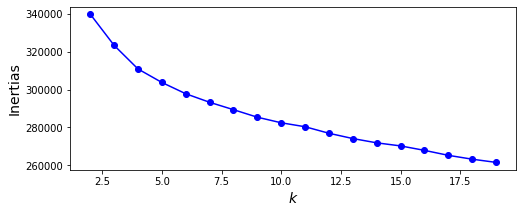

In [90]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertias", fontsize=14)
plt.show()

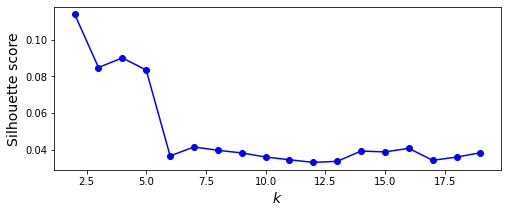

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

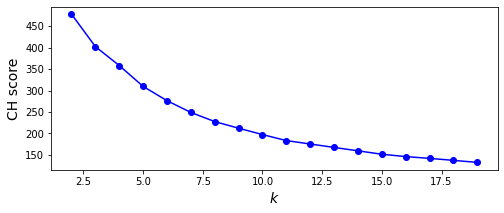

In [92]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, ch_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("CH score", fontsize=14)
plt.show()

-> This does not do what I want, I want to transform each observation to de distance to its centroid.

# v2
- clipping the the previousMarketCap feature destroys outliers. 
  - Filter clipping by kurtosis
  - Predict Increases
- Try to simulate a neural network with different algorithms